# Solving Burger's Equation

Burger's equation in convective (first equailty) and conservative (second equality) form reads
\begin{equation}
    \frac{\partial P}{\partial t} = -P \frac{\partial P}{\partial x} 
                                  = -\frac{1}{2}\frac{\partial P^2}{\partial t} .
    \end{equation}
In otherwords, the _flux function_ $F(P) := P^2/2$ is conserved:
\begin{equation}
    \frac{\partial P}{\partial t} + \frac{\partial F(P)}{\partial x} = 0 . 
    \end{equation}

In [222]:
import numpy as np
import matplotlib.pyplot as plt

L = 1
N = 3*90

T = 1
M = 3*100

xs = np.linspace(0, L, N)
ts = np.linspace(0, T, M)


def F(P):
    # Flux function for Burger's equation
    return -P*P / 2

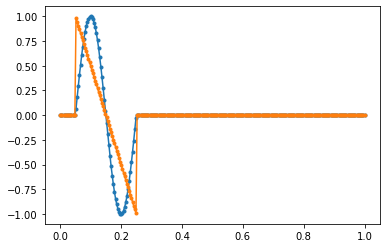

In [210]:
# A few possible initial conditions:

def Nwave(x, x0=0.05, d=0.05, h=1):
    out = np.zeros_like(x)
    f = h -(x-x0)* h/(2*d)
    mask = np.logical_and(f<=1, f>=-1)
    out[mask] = f[mask]
    return out

def sin(x, x0=0.15, d=0.05, h=1):
    out = np.zeros_like(x)
    f = -h*np.sin((x-x0)*np.pi/(d*2))
    mask = np.logical_and(x<=(x0+d*2), x>=(x0-d*2))
    out[mask] = f[mask]
    return out


plt.plot(xs, sin(xs), marker=".")
plt.plot(xs, Nwave(xs), marker=".")

In [211]:
dx = np.diff(xs)[0]
dt = np.diff(ts)[0]

G = 746.9
D1 = 0.04
D2 = 8.43
th1 = 0.4
th2 = 35.4
xs_r0 = 4.33

In [221]:
# A few possible solvers

def upwind(P, n):
    # assuming dF/dP >0
    return P[n, 1:-1] - dt/dx * ( F(P[n, 1:-1]) -  F(P[n, :-2]) )

def lax_wendroff(P, n):
    # "Two step method"
    Pm = (P[n, :-2] + P[n, 1:-1]) / 2 - dt / (2*dx) * ( F(P[n, 1:-1]) -  F(P[n, :-2]) )
    Pp = (P[n, 1:-1] + P[n, 2:]) / 2 - dt / (2*dx) * ( F(P[n, 2:]) -  F(P[n, 1:-1]) )
    return P[n, 1:-1] - dt/dx * (F(Pp) - F(Pm))
    
def lax_friedrich(P, n):
    # Best choice to avoid unwanted high-frequencies due to dissipation
    return (P[n, :-2] + P[n, 2:]) / 2 - dt / (2*dx) * ( F(P[n, 2:]) -  F(P[n, :-2]) )


def thermv(P, n):
    if n == 0:
        Pm = P[n, 1:-1]
    else:
        Pm = P[n-1, 1:-1]
    return 2 * dt * G / dx * np.exp(-xs_r0 * xs[1:-1]) * (P[n, 1:-1] - P[n, :-2]) + 2*P[n, 1:-1] - Pm
    
        

In [223]:
#solver = upwind
#solver = lax_wendroff
solver = lax_friedrich

P = np.zeros((M, N))
Z = = np.zeros((, N))
P[0, :] = sin(xs)
for n, t in enumerate(ts[1:-1]):
    #P[n, 1:-1] = solver(P, n)    
    P[n+1, 1:-1] = thermv(P, n)

<ipython-input-221-cf7d266189d6>:23: RuntimeWarning: overflow encountered in subtract
  return 2 * dt * G / dx * np.exp(-xs_r0 * xs[1:-1]) * (P[n, 1:-1] - P[n, :-2]) + 2*P[n, 1:-1] - Pm
<ipython-input-221-cf7d266189d6>:23: RuntimeWarning: overflow encountered in multiply
  return 2 * dt * G / dx * np.exp(-xs_r0 * xs[1:-1]) * (P[n, 1:-1] - P[n, :-2]) + 2*P[n, 1:-1] - Pm
<ipython-input-221-cf7d266189d6>:23: RuntimeWarning: invalid value encountered in subtract
  return 2 * dt * G / dx * np.exp(-xs_r0 * xs[1:-1]) * (P[n, 1:-1] - P[n, :-2]) + 2*P[n, 1:-1] - Pm
<ipython-input-221-cf7d266189d6>:23: RuntimeWarning: invalid value encountered in add
  return 2 * dt * G / dx * np.exp(-xs_r0 * xs[1:-1]) * (P[n, 1:-1] - P[n, :-2]) + 2*P[n, 1:-1] - Pm


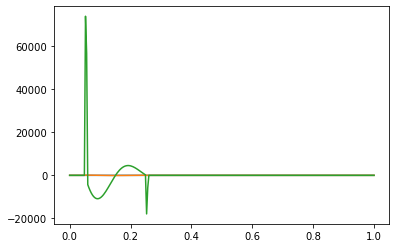

In [224]:
for p in P[:3]:
    plt.plot(xs, p)

In [171]:
def make_A(r, q, M):
    d = (1+2*r) * np.ones(M)
    d[0] = 1
    d[-1] = 1
    dup = -(r-q) * np.ones(M-1)
    dup[0] = 0
    dlo = -(r+q) * np.ones(M-1)
    dlo[-1] = 0
    return np.diag(d) + np.diag(dup, 1) + np.diag(dlo, -1)

def make_B(r, q, M):
    d = (1-2*r) * np.ones(M)
    d[0] = 1
    d[-1] = 1
    dup =(r+q) * np.ones(M-1)
    dup[0] = 0
    dlo = (r-q) * np.ones(M-1)
    dlo[-1] = 0
    return np.diag(d) + np.diag(dup, 1) + np.diag(dlo, -1)

In [172]:
make_A(0.5, 3, 5)

array([[ 1. ,  0. ,  0. ,  0. ,  0. ],
       [-3.5,  2. ,  2.5,  0. ,  0. ],
       [ 0. , -3.5,  2. ,  2.5,  0. ],
       [ 0. ,  0. , -3.5,  2. ,  2.5],
       [ 0. ,  0. ,  0. ,  0. ,  1. ]])

In [179]:


r0 = dx / (2*G*dt*dt)
q0 = 0
A0 = make_A(0.5, 3, M)
B0 = make_B(0.5, 3, M)

r1 = D1 * th1 * dx / (2*dt*dt)
q1 = th1 / (2*dt)


r1 = D1 * th1 * dx / (2*dt*dt)
q1 = th1 / (2*dt)

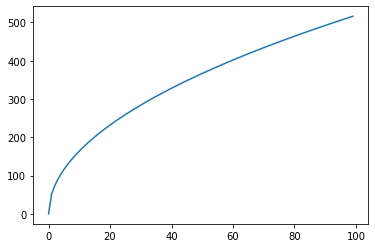

In [195]:
Ms = np.linspace(1,2, 100)
plt.plot(3*344 / 2 * np.sqrt(Ms - 1))

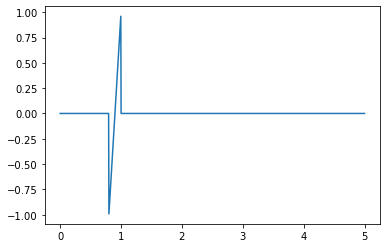

In [206]:
def Nwave(x, x0=0.0, d=0.05, h=1):
    out = np.zeros_like(x)
    f = h - (x-x0)* h/(2*d)
    mask = np.logical_and(f<=1, f>=-1)
    out[mask] = f[mask]
    return out

c=1
ts = np.linspace(0, 5, 1000)
plt.plot(ts, Nwave(0-c*ts, x0=-1))